In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Models
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [3]:
# Load data
df = pd.read_csv("../data/city_day.csv")

# Basic info
print("Initial shape:", df.shape)
print("Columns:", df.columns.tolist()[:30])

# Handle missing AQI with median (don’t remove, because important)
df['AQI'].fillna(df['AQI'].median(), inplace=True)

# Fill other numeric columns with mean
df.fillna(df.mean(numeric_only=True), inplace=True)

# Select important features (adjust if column names differ)
features = []
for c in ["PM2.5", "PM10", "NO", "NO2", "CO", "SO2", "NH3", "O3"]:
    if c in df.columns:
        features.append(c)
    else:
        print(f"Warning: Feature '{c}' not found in dataset and skipped.")

features.append("AQI")
df = df[features]

# Split into features & target
X = df.drop(columns=["AQI"])
y = df["AQI"]

# Impute numeric columns
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

Initial shape: (29531, 16)
Columns: ['City', 'Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket']


C:\Users\hp\AppData\Local\Temp\ipykernel_1396\1455743485.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['AQI'].fillna(df['AQI'].median(), inplace=True)


In [4]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:

# Define models (Gaussian replaced with Linear Regression)
models = {
    "Bayesian Ridge": BayesianRidge(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "Linear Regression": LinearRegression()
}

# Train, test & record results
results = []
for name, model in models.items():
    print(f"\nTraining {name} ...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    acc = 100 * (1 - np.mean(np.abs((y_test - y_pred) / np.where(y_test == 0, 1e-6, y_test))))

    results.append({"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2, "Accuracy (%)": acc})
    print(f"{name} done → MAE={mae:.3f}, RMSE={rmse:.3f}, R2={r2:.3f}, Accuracy%={acc:.2f}")

# Results DataFrame
results_df = pd.DataFrame(results)
print("\nFinal Comparison:\n", results_df.round(3))


Training Bayesian Ridge ...
Bayesian Ridge done → MAE=32.418, RMSE=55.941, R2=0.797, Accuracy%=77.08

Training Random Forest ...
Random Forest done → MAE=20.116, RMSE=41.999, R2=0.885, Accuracy%=86.30

Training Linear Regression ...
Linear Regression done → MAE=32.417, RMSE=55.940, R2=0.797, Accuracy%=77.08

Final Comparison:
                Model     MAE    RMSE     R2  Accuracy (%)
0     Bayesian Ridge  32.418  55.941  0.797        77.081
1      Random Forest  20.116  41.999  0.885        86.302
2  Linear Regression  32.417  55.940  0.797        77.082


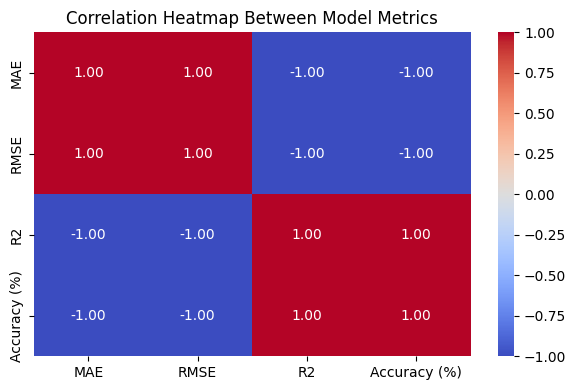

In [14]:
# Heatmap: correlation between metrics
plt.figure(figsize=(6, 4))
sns.heatmap(results_df.drop(columns=['Model']).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap Between Model Metrics')
plt.tight_layout()
plt.show()

In [15]:
# ---- Save Best Model ----
best_idx = results_df['RMSE'].idxmin()
best_name = results_df.loc[best_idx, 'Model']
print("\nBest Model (Lowest RMSE):", best_name)


Best Model (Lowest RMSE): Random Forest


In [16]:
if best_name == "Random Forest":
    final_model = RandomForestRegressor(n_estimators=200, random_state=42)
    final_model.fit(X_train_scaled, y_train)
    joblib.dump(final_model, "../models/final_random_forest_model.pkl")
    joblib.dump(scaler, "../models/scaler.pkl")
    joblib.dump(imputer, "../models/imputer.pkl")
    print("✅ Saved Random Forest + scaler + imputer in ../models/")
else:
    print("Best model is not Random Forest — manual save skipped.")

✅ Saved Random Forest + scaler + imputer in ../models/


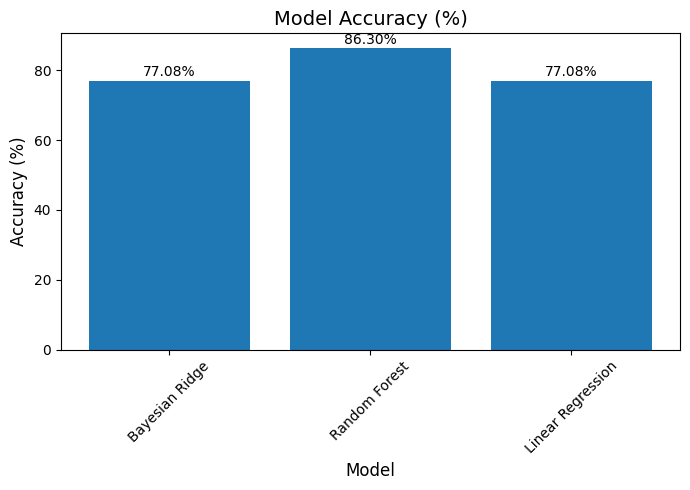

In [18]:
plt.figure(figsize=(7,5))
models = results_df["Model"].tolist()
bars = plt.bar(models, results_df["Accuracy (%)"])

plt.title("Model Accuracy (%)", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.xticks(rotation=45)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.5,
        f"{height:.2f}%",
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()


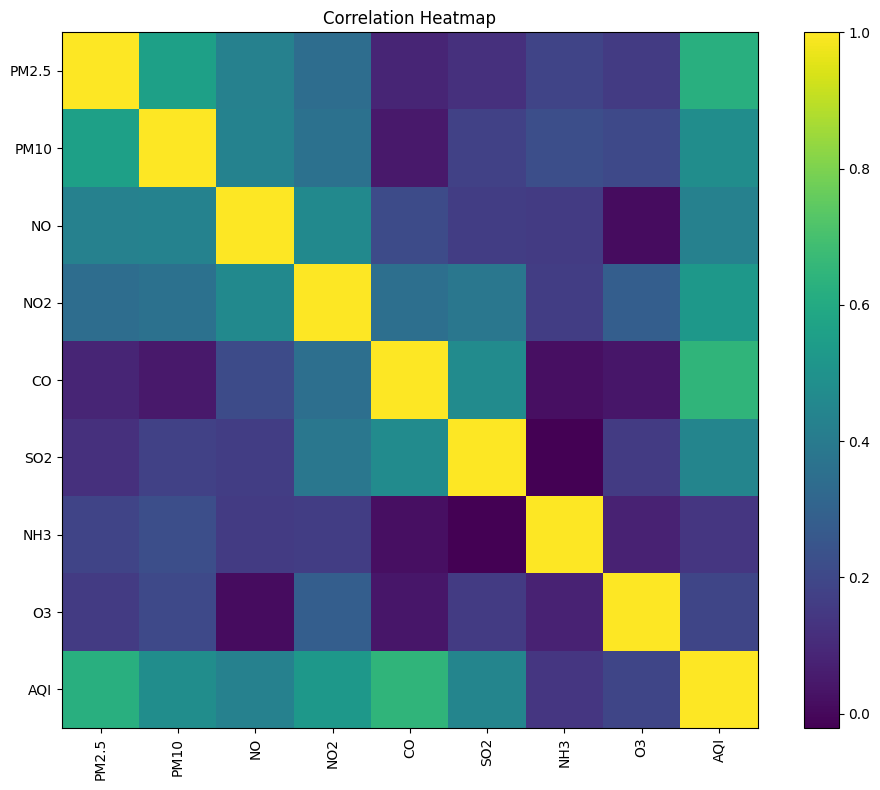

In [19]:
corr = df.corr()      # replace df with your main dataframe

plt.figure(figsize=(10, 8))
plt.imshow(corr, interpolation='nearest')
plt.colorbar()

plt.xticks(ticks=np.arange(len(corr.columns)), labels=corr.columns, rotation=90)
plt.yticks(ticks=np.arange(len(corr.columns)), labels=corr.columns)

plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

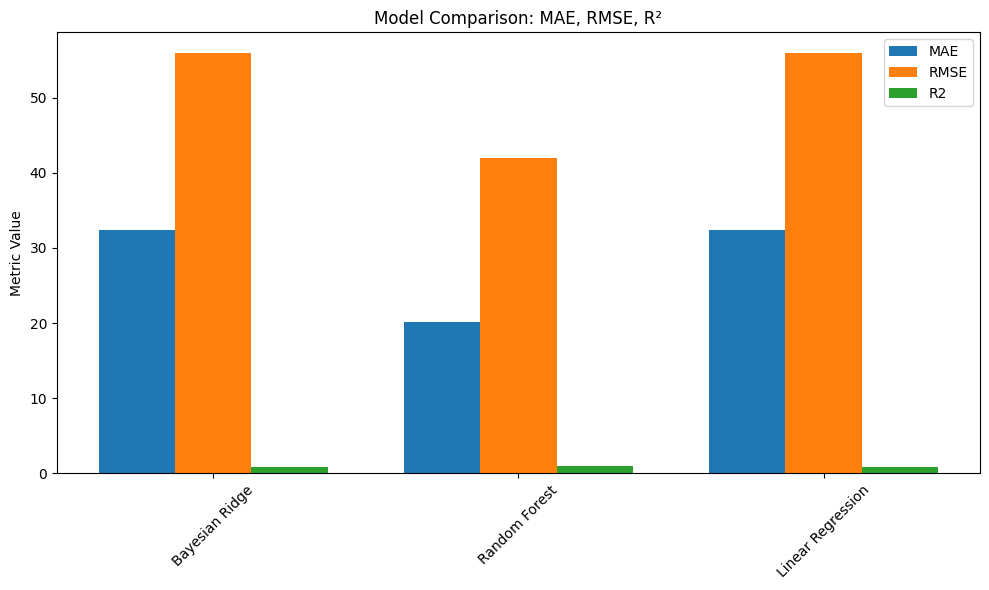

In [ ]:
# Extract model names (important)
models = results_df["Model"].tolist()
# Extract metric values
mae = results_df["MAE"]
rmse = results_df["RMSE"]
r2 = results_df["R2"]
x = np.arange(len(models))
width = 0.25
plt.figure(figsize=(10,6))
# Bars
plt.bar(x - width, mae, width, label="MAE")
plt.bar(x, rmse, width, label="RMSE")
plt.bar(x + width, r2, width, label="R2")
# Labels & formatting
plt.xticks(x, models, rotation=45)
plt.ylabel("Metric Value")
plt.title("Model Comparison: MAE, RMSE, R²")
plt.legend()
plt.tight_layout()

plt.show()
